# CRIME DETECTION SYSTEM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap
import pymysql
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### DB Connection

In [2]:
def db(): 
    host = "localhost"
    user = "root"
    password = "root"
    database = "crime_detection"

    return pymysql.connect(host=host, user=user, password=password, db=database)

### Load Data

In [3]:
crime_data = None

In [4]:
def load_by_csv():
    global crime_data
    raw_data = pd.read_csv('Crime_Data_from_2010_to_2019.csv')
    #If the dataset read from cvs file, change the name of the columns to complete the data cleaning
    raw_data.rename(columns={
    'DR_NO': 'dr_no',
    'Date Rptd': 'date_rptd',
    'DATE OCC': 'date_occ',
    'TIME OCC': 'time_occ',
    'AREA ': 'area',
    'AREA NAME': 'area_name',
    'Rpt Dist No': 'rpt_dist_no',
    'Part 1-2': 'part_1-2',
    'Crm Cd': 'crm_cd',
    'Crm Cd Desc': 'crm_cd_desc',
    'Mocodes': 'mocodes',
    'Vict Age': 'vict_age',
    'Vict Sex': 'vict_sex',
    'Vict Descent': 'vict_descent',
    'Premis Cd': 'premis_cd',
    'Premis Desc': 'premis_desc',
    'Weapon Used Cd': 'weapon_used_cd',
    'Weapon Desc': 'weapon_desc',
    'Status': 'status',
    'Status Desc': 'status_desc',
    'Crm Cd 1': 'crm_cd_1',
    'Crm Cd 2': 'crm_cd_2',
    'Crm Cd 3': 'crm_cd_3',
    'Crm Cd 4': 'crm_cd_4',
    'LOCATION': 'location',
    'Cross Street': 'cross_street',
    'LAT': 'lat',
    'LON': 'lon',              
    },inplace= True)
    
    crime_data = raw_data[[
        'date_rptd',
        'date_occ',
        'time_occ',
        'area',
        'area_name',
        'crm_cd',
        'crm_cd_desc',
        'vict_age',
        'vict_sex',
        'vict_descent',
        'premis_cd',
        'premis_desc',
        'weapon_used_cd',
        'weapon_desc',
        'location',
        'lat',
        'lon' 
    ]]

In [5]:
def load_by_db():
    global crime_data
    connection = db()
    sql_query = """SELECT
    'date_rptd',
    'date_occ',
    'time_occ',
    'area',
    'area_name',
    'crm_cd',
    'crm_cd_desc',
    'vict_age',
    'vict_sex',
    'vict_descent',
    'premis_cd',
    'premis_desc',
    'weapon_used_cd',
    'weapon_desc',
    'location',
    'lat',
    'lon'
    FROM raw_data"""
    crime_data = pd.read_sql(sql_query, connection)
    connection.close()

In [6]:
source_type = 'CSV'
if source_type == 'DB':
    print("DB...")
    load_by_db()

elif source_type == 'CSV':
    print("CSV...")
    load_by_csv()
else:
    raise Exception('Chose a data source ("DB" or "CSV")')

CSV...


In [7]:
crime_data.head()

,date_rptd,date_occ,time_occ,area,area_name,crm_cd,crm_cd_desc,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,location,lat,lon
0,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,900,VIOLATION OF COURT ORDER,48,M,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,300 E GAGE AV,33.9825,-118.2695
1,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,101.0,STREET,NaN,NaN,SEPULVEDA BL,33.9599,-118.3962
2,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,946,OTHER MISCELLANEOUS CRIME,0,M,H,103.0,ALLEY,NaN,NaN,1300 E 21ST ST,34.0224,-118.2524
3,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,900,VIOLATION OF COURT ORDER,47,F,W,101.0,STREET,102.0,HAND GUN,CAHUENGA BL,34.1016,-118.3295
4,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,122,"RAPE, ATTEMPTED",47,F,H,103.0,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",8TH ST,34.0387,-118.2488


In [8]:
crime_data.tail()

,date_rptd,date_occ,time_occ,area,area_name,crm_cd,crm_cd_desc,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,location,lat,lon
2123039,02/22/2019 12:00:00 AM,02/22/2019 12:00:00 AM,840,5,Harbor,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,14,F,W,109.0,PARK/PLAYGROUND,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",100 W 22ND ST,33.7257,-118.2801
2123040,03/28/2019 12:00:00 AM,03/28/2019 12:00:00 AM,400,6,Hollywood,648,ARSON,0,X,X,706.0,SEX ORIENTED/BOOK STORE/STRIP CLUB/GENTLEMAN'S...,506.0,FIRE,1400 N LA BREA AV,34.0962,-118.3490
2123041,01/06/2019 12:00:00 AM,01/06/2019 12:00:00 AM,2100,20,Olympic,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,46,F,B,102.0,SIDEWALK,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",6TH,34.0637,-118.2870
2123042,10/17/2019 12:00:00 AM,10/16/2019 12:00:00 AM,1800,17,Devonshire,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0,NaN,NaN,101.0,STREET,NaN,NaN,17200 NAPA ST,34.2266,-118.5085
2123043,02/01/2019 12:00:00 AM,02/01/2019 12:00:00 AM,1615,8,West LA,330,BURGLARY FROM VEHICLE,33,F,W,707.0,GARAGE/CARPORT,NaN,NaN,1700 BARRY AV,34.0420,-118.4531


Dataframe columns name

In [9]:
print(crime_data.columns)

Index(['date_rptd', 'date_occ', 'time_occ', 'area', 'area_name', 'crm_cd',
       'crm_cd_desc', 'vict_age', 'vict_sex', 'vict_descent', 'premis_cd',
       'premis_desc', 'weapon_used_cd', 'weapon_desc', 'location', 'lat',
       'lon'],
      dtype='object')


Dataframe columns info

In [10]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123044 entries, 0 to 2123043
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_rptd       object 
 1   date_occ        object 
 2   time_occ        int64  
 3   area            int64  
 4   area_name       object 
 5   crm_cd          int64  
 6   crm_cd_desc     object 
 7   vict_age        int64  
 8   vict_sex        object 
 9   vict_descent    object 
 10  premis_cd       float64
 11  premis_desc     object 
 12  weapon_used_cd  float64
 13  weapon_desc     object 
 14  location        object 
 15  lat             float64
 16  lon             float64
dtypes: float64(4), int64(4), object(9)
memory usage: 275.4+ MB


The columns of the dataset are:
1. DR_NO: Report number for the incident (int64)
2. Date Rptd: Date the incident was reported (object, might need to be converted to a datetime format)
3. DATE OCC: Date of occurrence of the incident (object, might need to be converted to a datetime format)
4. TIME OCC: Time of occurrence of the incident (int64)
5. AREA: Area code related to the incident (int64)
6. AREA NAME: Name of the area related to the incident (object)
7. Rpt Dist No: Report district number (int64)
8. Part 1-2: Classification of the incident (int64)
9. Crm Cd: Crime code (int64)
10. Crm Cd Desc: Description of the crime code (object)
11. Mocodes: Modus operandi codes (object)
12. Vict Age: Age of the victim (int64)
13. Vict Sex: Sex of the victim (object)
14. Vict Descent: Descent of the victim (object)
15. Premis Cd: Premises code (float64)
16. Premis Desc: Description of the premises (object)
17. Weapon Used Cd: Weapon code used (float64)
18. Weapon Desc: Description of the weapon used (object)
19. Status: Status of the incident (object)
20. Status Desc: Description of the status (object)
21. Crm Cd 1-4: Additional crime codes (float64)
22. LOCATION: Location of the incident (object)
23. Cross Street: Cross street of the incident (object)
24. LAT: Latitude coordinates (float64)
25. LON: Longitude coordinates (float64)

In [11]:
crime_data.shape

(2123044, 17)

In [12]:
crime_data.isnull().sum()

date_rptd               0
date_occ                0
time_occ                0
area                    0
area_name               0
crm_cd                  0
crm_cd_desc             0
vict_age                0
vict_sex           196818
vict_descent       196864
premis_cd              53
premis_desc           187
weapon_used_cd    1409313
weapon_desc       1409314
location                0
lat                     0
lon                     0
dtype: int64

### Preprocessing & Visualisation

#### Date of Crime Reported and Crime Occurred Converting

Spliting Crime Reported, converting to date time Crime Reported and droping column date_time_rptd

In [13]:
crime_data['date_time_rptd'] = crime_data['date_rptd'].str.split()
crime_data['date_rptd'] = pd.to_datetime(crime_data['date_time_rptd'].apply(lambda x: x[0]), format="%m/%d/%Y")
crime_data['time_rptd'] = crime_data['date_time_rptd'].apply(lambda x: x[1])
crime_data.drop(columns=['date_time_rptd'], inplace=True, axis=1)

Spliting Crime Occurred, converting to date time Crime Occurred and droping column date_time_occ

In [14]:
crime_data['date_time_occ'] = crime_data['date_occ'].str.split()
crime_data['date_occ'] = pd.to_datetime(crime_data['date_time_occ'].apply(lambda x: x[0]), format="%m/%d/%Y")
crime_data['time_occ'] = crime_data['date_time_occ'].apply(lambda x: x[1])
crime_data.drop(columns=['date_time_occ'], inplace=True, axis=1)

Create year field from date_occ

In [15]:
crime_data['year'] = crime_data['date_occ'].dt.strftime('%Y')

Filter the data for the years 2010 to 2019  
Group by year and count the total criminal cases for each year

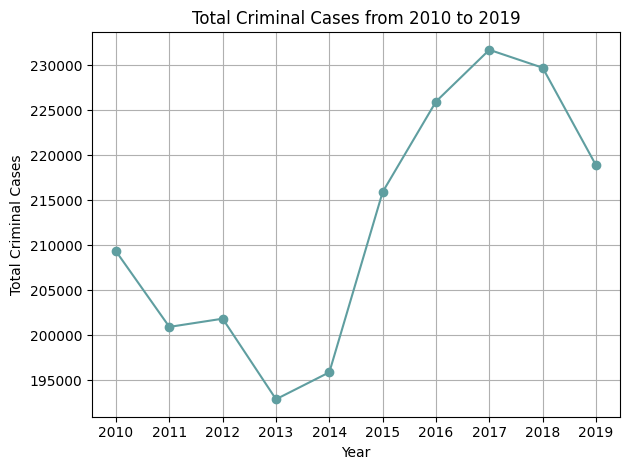

In [16]:
crime_by_year = crime_data[(crime_data['year'] >= '2010') & (crime_data['year'] <= '2019')].groupby('year').size()
plt.plot(crime_by_year.index, crime_by_year.values, marker='o', linestyle='-', color = 'cadetblue')
plt.title('Total Criminal Cases from 2010 to 2019')
plt.xlabel('Year')
plt.ylabel('Total Criminal Cases')
plt.grid(True)
plt.xticks(crime_by_year.index)
plt.tight_layout()
plt.show()

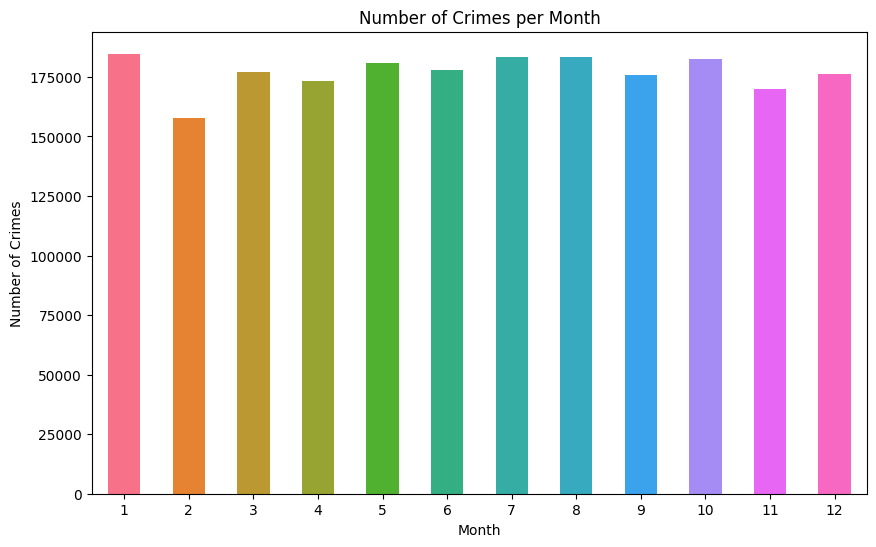

In [17]:
crimes_per_month = crime_data['date_occ'].dt.month.value_counts().sort_index()
num_months = len(crimes_per_month)
palette = sns.color_palette("husl", num_months)
plt.figure(figsize=(10, 6))
crimes_per_month.plot(kind='bar', color=palette)
plt.title('Number of Crimes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)  # Keep x-axis labels vertical
plt.show()

#### Area

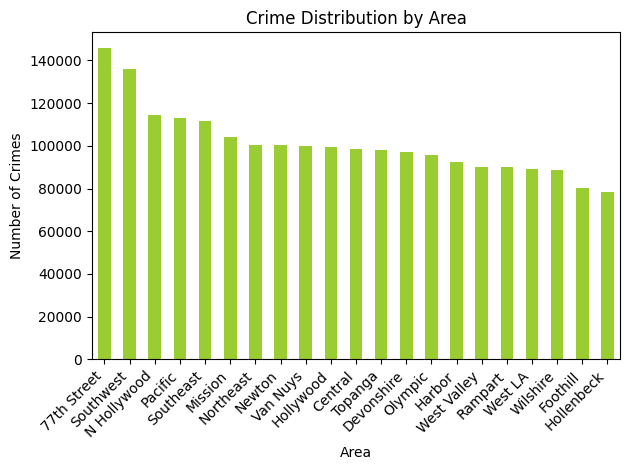

In [18]:
# Grouping data by 'AREA NAME' and counting occurrences
crime_by_area = crime_data['area_name'].value_counts()
crime_by_area.plot(kind='bar', color='yellowgreen')
plt.title('Crime Distribution by Area')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

#### Crime

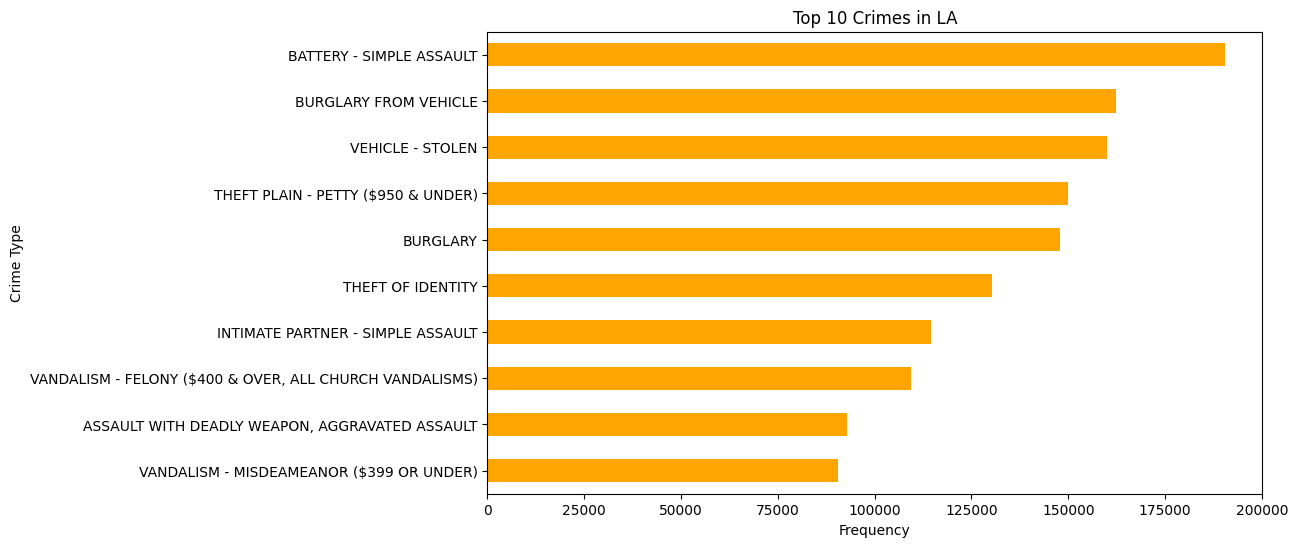

In [19]:
top_crime_types = crime_data['crm_cd_desc'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_crime_types.plot(kind='barh', color='orange')
plt.title('Top 10 Crimes in LA')
plt.xlabel('Frequency')
plt.ylabel('Crime Type')
plt.gca().invert_yaxis()
plt.show()

In [20]:
crime_data['weapon_desc'].value_counts()

weapon_desc
STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    433685
VERBAL THREAT                                      58728
UNKNOWN WEAPON/OTHER WEAPON                        57545
HAND GUN                                           34125
SEMI-AUTOMATIC PISTOL                              12913
                                                   ...  
MAC-10 SEMIAUTOMATIC ASSAULT WEAPON                   11
ANTIQUE FIREARM                                        9
MAC-11 SEMIAUTOMATIC ASSAULT WEAPON                    7
M1-1 SEMIAUTOMATIC ASSAULT RIFLE                       3
M-14 SEMIAUTOMATIC ASSAULT RIFLE                       1
Name: count, Length: 79, dtype: int64

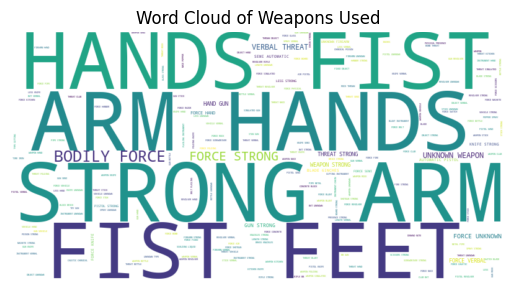

In [21]:
weapons_text = ' '.join(crime_data['weapon_desc'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(weapons_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Weapons Used')
plt.show()

#### Victim

In [22]:
# Calculate the mean of non-zero positive ages
mean_age = np.mean(crime_data.loc[(crime_data['vict_age'] > 0), 'vict_age'])
crime_data.loc[(crime_data['vict_age'] <= 0), 'vict_age'] = mean_age
crime_data['vict_age'] = crime_data['vict_age'].astype(int)

crime_data.head()

C:\Users\ananb\AppData\Local\Temp\ipykernel_11208\3456460027.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '38.464868168953316' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crime_data.loc[(crime_data['vict_age'] <= 0), 'vict_age'] = mean_age


,date_rptd,date_occ,time_occ,area,area_name,crm_cd,crm_cd_desc,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,location,lat,lon,time_rptd,year
0,2010-02-20,2010-02-20,12:00:00,13,Newton,900,VIOLATION OF COURT ORDER,48,M,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,300 E GAGE AV,33.9825,-118.2695,12:00:00,2010
1,2010-09-13,2010-09-12,12:00:00,14,Pacific,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",38,M,W,101.0,STREET,NaN,NaN,SEPULVEDA BL,33.9599,-118.3962,12:00:00,2010
2,2010-08-09,2010-08-09,12:00:00,13,Newton,946,OTHER MISCELLANEOUS CRIME,38,M,H,103.0,ALLEY,NaN,NaN,1300 E 21ST ST,34.0224,-118.2524,12:00:00,2010
3,2010-01-05,2010-01-05,12:00:00,6,Hollywood,900,VIOLATION OF COURT ORDER,47,F,W,101.0,STREET,102.0,HAND GUN,CAHUENGA BL,34.1016,-118.3295,12:00:00,2010
4,2010-01-03,2010-01-02,12:00:00,1,Central,122,"RAPE, ATTEMPTED",47,F,H,103.0,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",8TH ST,34.0387,-118.2488,12:00:00,2010


In [23]:
crime_data['vict_sex'].unique()

array(['M', 'F', nan, 'X', 'H', '-', 'N'], dtype=object)

In [24]:
crime_data['vict_sex'] = crime_data['vict_sex'].replace('nan', np.nan)

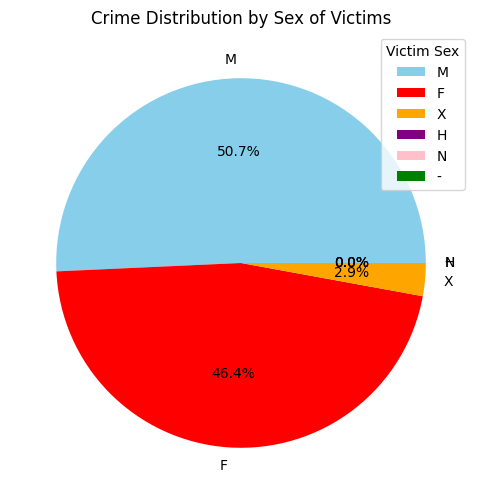

In [25]:
plt.figure(figsize=(8, 6))
crime_data['vict_sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'red', 'orange','purple', 'pink','green'])
plt.title('Crime Distribution by Sex of Victims')
plt.ylabel('')
plt.legend(title='Victim Sex', loc='upper right')
plt.show()

In [26]:
crime_data['vict_sex'] = crime_data["vict_sex"].replace(['H', 'N','-'], 'X')
crime_data['vict_sex'].value_counts()

vict_sex
M    977042
F    893785
X     55399
Name: count, dtype: int64

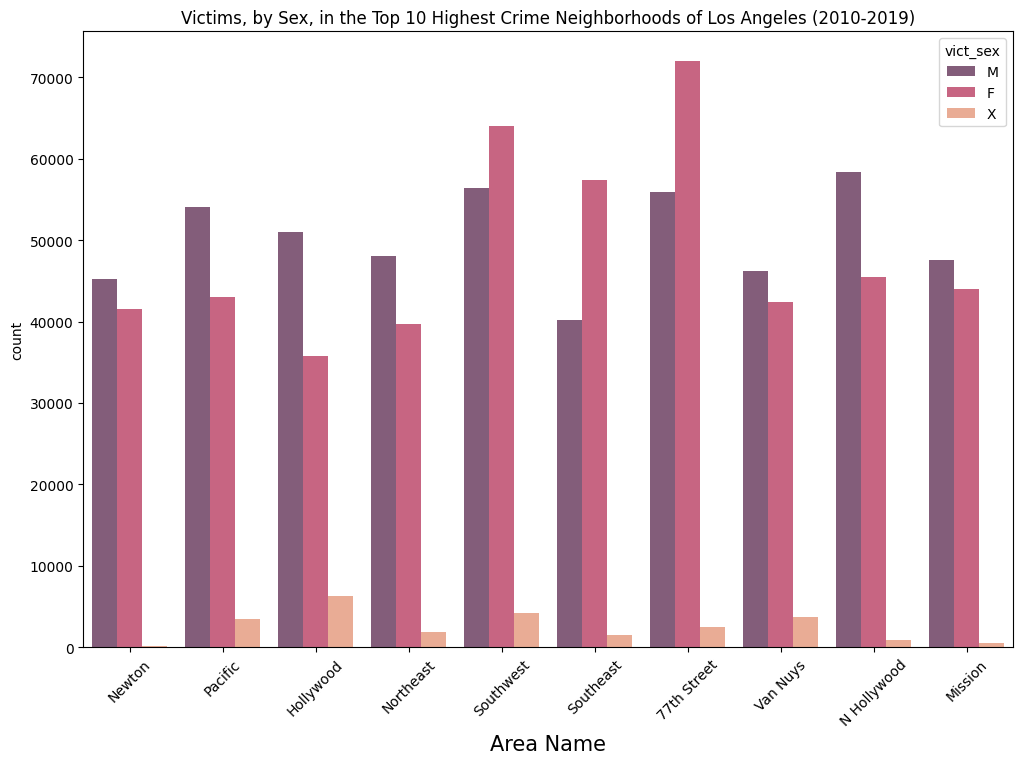

In [27]:
top_10_areas = crime_data['area_name'].value_counts().head(10).index.tolist()
df_top_10_areas = crime_data[crime_data['area_name'].isin(top_10_areas)]

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='area_name', hue='vict_sex', data=df_top_10_areas, palette='rocket', alpha=0.75)
ax.set_title('Victims, by Sex, in the Top 10 Highest Crime Neighborhoods of Los Angeles (2010-2019)')
ax.set_xlabel('Area Name', fontsize=15)
plt.xticks(rotation=45) 
plt.show()

In [28]:
victims = {
      "A": "Asian",
      "B": "Black",
      "C": "Chinese",
      "D": "Cambodian",
      "F": "Filipino",
      "G": "Guamanian",
      "H": "Hispanic/Latin/Mexican",
      "I": "American Indian/Alaskan Native",
      "J": "Japanese",
      "K": "Korean",
      "L": "Laotian",
      "O": "Other",
      "P": "Pacific Islander",
      "S": "Samoan",
      "U": "Hawaiian",
      "V": "Vietnamese",
      "W": "White",
      "X": "Unknown",
      "Z": "Asian Indian"
  }

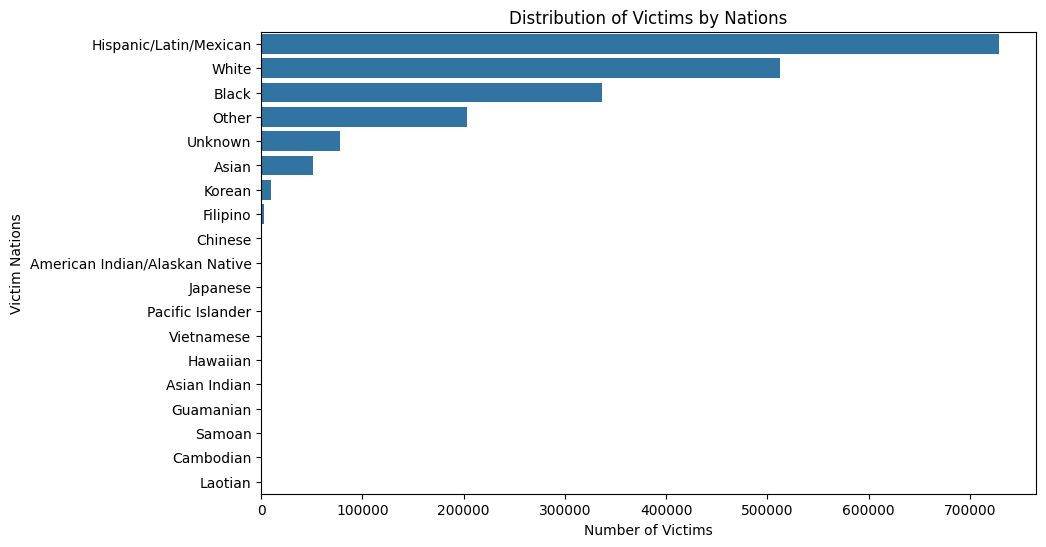

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=crime_data['vict_descent'].map(victims), order=crime_data['vict_descent'].map(victims).value_counts().index)
plt.title('Distribution of Victims by Nations')
plt.ylabel('Victim Nations')
plt.xlabel('Number of Victims')
plt.show()

In [30]:
crime_data = crime_data.dropna(subset=['vict_sex', 'vict_descent'])

In [31]:
crime_data.shape

(1926177, 19)

In [32]:
aggregated_data = crime_data.groupby(['lat', 'lon']).size().reset_index(name='crime_count')
la_latitude = 34.052235
la_longitude = -118.243683
la_map = folium.Map(location=[la_latitude, la_longitude], zoom_start=10)

# Create a HeatMap layer using the aggregated crime data
heat_data = aggregated_data[['lat', 'lon', 'crime_count']].values.tolist()
HeatMap(heat_data, radius=15).add_to(la_map)

# Display the map
la_map

### Crime Prediction

Selecting features and the target variable

In [33]:
features = ['lat', 'lon', 'time_occ', 'area', 'year'] 
target = 'crm_cd'

X = crime_data[features]
y = crime_data[target]

Applying get_dummies to convert categorical features into dummy/indicator variables

In [34]:
X = pd.get_dummies(X, columns=['time_occ', 'area', 'year'])

Preprocessing for continuous features

In [35]:
continuous_features = ['lat', 'lon']
continuous_transformer = StandardScaler()


Creating a ColumnTransformer that will apply the transformations to the respective features

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features)])


Defining and training the Random Forest model

In [37]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(n_jobs=2, max_depth=5))])


Defining and training the Decision Tree model

In [38]:
dt = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', DecisionTreeClassifier(max_depth=5))])


Splitting the dataset into training and testing sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Training the Random Forest model and calculating cross-validation scores

In [40]:
rf.fit(X_train, y_train)
rf_cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f"Cross Validation Accuracy Rates: {rf_cross_val_scores}")
print(f"Average Cross Validation Accuracy: {np.mean(rf_cross_val_scores)}")


c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross Validation Accuracy Rates: [0.11961879 0.11933696 0.12082399 0.1194709  0.1193819 ]
Average Cross Validation Accuracy: 0.11972650425735235


Training the Decision Tree model and calculating cross-validation scores

In [41]:
dt.fit(X_train, y_train)
dt_cross_val_scores = cross_val_score(dt, X_train, y_train, cv=5)
print(f"Cross Validation Accuracy Rates: {dt_cross_val_scores}")
print(f"Average Cross Validation Accuracy: {np.mean(dt_cross_val_scores)}")


c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross Validation Accuracy Rates: [0.11648898 0.11686722 0.11784622 0.1166192  0.11669337]
Average Cross Validation Accuracy: 0.11690299691288579


Evaluating the Random Forest model

In [42]:
rf_y_pred = rf.predict(X_test)
print(f"Random Forest Model Accuracy: {accuracy_score(y_test, rf_y_pred)}")
print(classification_report(y_test, rf_y_pred))


Random Forest Model Accuracy: 0.1191754318564897


c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         110       0.00      0.00      0.00       841
         113       0.00      0.00      0.00         1
         121       0.00      0.00      0.00      3250
         122       0.00      0.00      0.00       332
         210       0.00      0.00      0.00     25263
         220       0.00      0.00      0.00      3622
         230       0.00      0.00      0.00     27966
         231       0.00      0.00      0.00       475
         235       0.00      0.00      0.00       509
         236       0.00      0.00      0.00      4532
         237       0.00      0.00      0.00      1616
         250       0.00      0.00      0.00        81
         251       0.00      0.00      0.00       788
         310       0.12      0.24      0.16     44077
         320       0.00      0.00      0.00      3775
         330       0.13      0.20      0.16     48428
         331       0.00      0.00      0.00      9523
         341       0.32    

c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating the Decision Tree model

In [43]:
dt_y_pred = dt.predict(X_test)
print(f"Decision Tree Model Accuracy: {accuracy_score(y_test, dt_y_pred)}")
print(classification_report(y_test, dt_y_pred))


Decision Tree Model Accuracy: 0.11594105085367584


c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         110       0.00      0.00      0.00       841
         113       0.00      0.00      0.00         1
         121       0.00      0.00      0.00      3250
         122       0.00      0.00      0.00       332
         210       0.00      0.00      0.00     25263
         220       0.00      0.00      0.00      3622
         230       0.00      0.00      0.00     27966
         231       0.00      0.00      0.00       475
         235       0.00      0.00      0.00       509
         236       0.00      0.00      0.00      4532
         237       0.00      0.00      0.00      1616
         250       0.00      0.00      0.00        81
         251       0.00      0.00      0.00       788
         310       0.11      0.25      0.15     44077
         320       0.00      0.00      0.00      3775
         330       0.12      0.21      0.15     48428
         331       0.00      0.00      0.00      9523
         341       0.31    

c:\Users\ananb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
